In [1]:
# import libraries
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")
!unzip '/content/gdrive/MyDrive/2.zip'

Streaming output truncated to the last 5000 lines.
 extracting: 1/train/bird/emu_s_000219.png  
 extracting: 1/train/bird/pipit_s_000192.png  
 extracting: 1/train/bird/flightless_bird_s_000562.png  
 extracting: 1/train/bird/passerine_s_001221.png  
 extracting: 1/train/bird/struthio_camelus_s_000008.png  
  inflating: 1/train/bird/pipit_s_000221.png  
 extracting: 1/train/bird/passerine_s_001226.png  
 extracting: 1/train/bird/emu_s_001158.png  
 extracting: 1/train/bird/accentor_s_000039.png  
 extracting: 1/train/bird/pipit_s_000029.png  
 extracting: 1/train/bird/ostrich_s_002262.png  
 extracting: 1/train/bird/struthio_camelus_s_000156.png  
  inflating: 1/train/bird/flightless_bird_s_000353.png  
 extracting: 1/train/bird/pipit_s_000443.png  
 extracting: 1/train/bird/ostrich_s_000506.png  
  inflating: 1/train/bird/sparrow_s_000490.png  
  inflating: 1/train/bird/ostrich_s_002057.png  
  inflating: 1/train/bird/meadow_pipit_s_000610.png  
 extracting: 1/train/bird/cassowary_s_0

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)


        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=1024)
        self.fc5 = nn.Linear(in_features=1024, out_features=5)

         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x=self.fc5(x)
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()
net.load_state_dict(torch.load("/content/gdrive/MyDrive/new model.pth"))
# torch.load(f="/content/gdrive/MyDrive/new model.pth", map_location=torch.device('cpu'))




<All keys matched successfully>

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])

test_data_dir = "/content/1/test"

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)

In [6]:
# copy atensor by .clone().detach()
x = torch.tensor([1, 2, 3])
y1 = x.clone().detach()
y2 = torch.tensor(x)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


tensor([1, 2, 3])

In [ ]:
len(testset)
testset[0].shape

In [7]:
def occlusion(net,img,label,N):
 
  
  imgw=img.shape[-1]
  imgh=img.shape[-2]
  outw=imgw-N+1
  outh=imgh-N+1
  heatmap = torch.zeros((outw, outh))
  for top in range(outw):
    bottom=top+N
    for left in range(outh):
      right=left+N
      # copy of imagepizel value of gey 

      cimg=img.clone().detach()
      # chaing those pixels to black
      cimg[:,:,top:bottom,left:right]=1
      output=net(cimg)
      output = F.softmax(output, dim=1)

      heatmap[top, left] = output[0][label]
    
  return heatmap





In [20]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def display(img, ax, title=None):
    img=img.cpu()
    npimg = img.numpy()
    npimg = npimg-np.min(npimg)/abs(np.max(npimg)-np.min(npimg))
    #plot the image as numpy array
    ax.axis("off")
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if title!=None:
        ax.set_title(title)


In [ ]:
def images(i):
    #considers one image 
    image, label = testloader.dataset[i]
    outputs = net(image[None,:,:,:])
    _, predicted = torch.max(outputs, 1)
    print('True Class--'+classes[label] + '\n Predicted Class-- '+ classes[predicted])
    
    display(image,i)
# images(1307)

In [22]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

########################################################################
# load-model - returns DataLoader for image dataset
# def get_loader(data_dir, transform=None,batch_size=1,shuffle=False):
#     dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle, num_workers=2)
#     return dataloader


########################################################################
# display image tensor with 3 channels
# def dispaly(img, ax, title=None):
#     # Image = np.clip(allimages[i], 0, 1)
#     npimg = img.numpy()
#     npimg=npimg-np.min(npimg/abs(np.max(npimg)-np.min(npimg))
    
  
#     #plot the image as numpy array
#     ax.axis("off")
#     ax.imshow(np.transpose(npimg, (1, 2, 0)))
#     if title!=None:
#         ax.set_title(title)


100%|██████████| 45/45 [00:02<00:00, 20.07it/s]


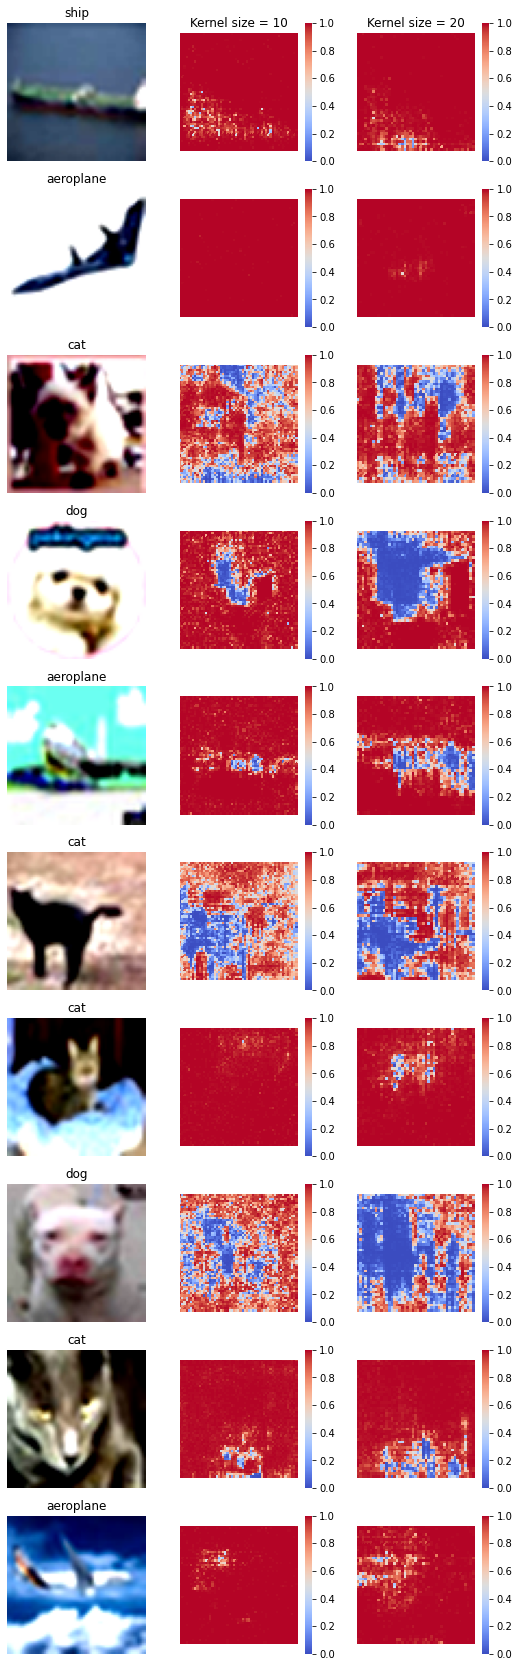

In [25]:
import torch
from torchvision.transforms import transforms
import torch.nn.functional as F

########################################################################
# Finds and returns probablity heatmap for grayscaling heatmap
def occlusion(net, img, label, kernel_size):
    
    width, height = img.shape[-1], img.shape[-2]
    
    heatmap = torch.zeros((height-kernel_size+1, width-kernel_size+1))
    
    for top in tqdm(range(height-kernel_size+1)):
        bottom = top+kernel_size
        for left in range(width-kernel_size+1):
            right = left+kernel_size
            
            #grayscale img tensor in required window
            img_clone = img.clone().detach()
            
            img_clone[:, :, top:bottom, left:right] = 0.5

            #run inference on modified image
            output = net(img_clone)

            #convert loss to probability
            output = F.softmax(output, dim=1)

            heatmap[top, left] = output[0][label]
    
    return heatmap



########################################################################
# Import best performing model


# net = Net4()
# if torch.cuda.is_available():
#     net = net.cuda()

# net.load_state_dict(checkpoint['model_state_dict'])

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

########################################################################
# Select images for occlusion
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])

# test_data_dir = '../dataset/test' 
# testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)

subset_indices = np.random.randint(2500,size=10) #select 5 images
subset = torch.utils.data.Subset(testset, subset_indices)

evalloader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)
evaliter = iter(evalloader)
classes, _ = find_classes(test_data_dir)

########################################################################
# Plot heatmaps as subplots
kernel_size = [10,20]

cols = ['Kernel size = {}'.format(k) for k in kernel_size]
fig_fname = '../images/Occlusion_heatmaps.png'
fig, axes = plt.subplots(nrows = len(subset), ncols=3, figsize=(9,3*len(subset)))

for i in range(len(kernel_size)):
    axes[0,(i+1)].set_title(cols[i])
    
idx=0
with torch.no_grad():   
    for data in evalloader:
        image, label = data
        if torch.cuda.is_available():
            image, label = image.cuda(), label.cuda()
        
        display(image[0],axes[idx,0],classes[label])
        
        idy=1
        for k in kernel_size:
            
            heatmap = occlusion(net, image, label, k)
            sns.heatmap(heatmap, vmin=0, vmax=1,xticklabels=False,yticklabels=False,
                        ax=axes[idx,idy], square=True, cmap='coolwarm')
            idy+=1
            
        idx+=1  

# plt.savefig(fig_fname, bbox_inches='tight')
plt.show()



In [ ]:
# useless
def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/bestmodelfilter16.pth')
